In [1]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv
from IPython.display import Image
from matplotlib import pyplot as plt
from matplotlib import colors
from random import shuffle
from itertools import cycle, chain
from collections import defaultdict
import json
import yaml

%matplotlib inline

In [2]:
def plt_draw(graph, colors=None, figsize=(30,30)):
    if colors is None:
        colors = ["white" for n in graph.nodes]
    plt.figure(figsize=figsize)
    pos = graphviz_layout(graph, prog="dot")
    nx.draw(graph, with_labels=True, node_color=colors)

In [3]:
css_colors = list(colors.CSS4_COLORS.keys())
shuffle(css_colors)
colors = list(colors.BASE_COLORS.keys()) + css_colors
colors = cycle(colors)

In [4]:
def do_wave(n, color):
    print("Starting wave", n)
    waves[n] = list()
    for package in waves[n-1]:
        print(f"# {package}")
        what_requires = !dnf --repo=rawhide repoquery --qf '%{{NAME}}' --whatrequires {package} 2> /dev/null
        for dependant in what_requires:
            if dependant in exceptions:
                print("X", dependant, "has an exception")
                continue
            if dependant not in g.nodes:
                print("A", dependant, "→", package)
                waves[n].append(dependant)
                g.add_edge(dependant, package)
                node_colors.append(color)
    print(len(waves[n]), "new packages")
    return len(waves[n])

## Maintainers

In [5]:
with open("pagure_owner_alias.json") as fh:
    maintainers = json.load(fh)["rpms"]

## Exceptions

Get groups from portingdb

In [6]:
with open("/home/lbalhar/Dropbox/Projekty/portingdb/data/groups.yaml") as fh:
    groups = yaml.load(fh)

/home/lbalhar/.virtualenvs/python2_removal/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


Get all non-hidden source RPM packages (have an exception)

In [7]:
source_packages = []
for srpm, info in groups.items():
    if info.get("hidden", False):
        continue
    for package in info["packages"]:
        source_packages.append(package)

Get mapping from portingdb to get binary RPMs from source RPMs

In [8]:
with open("/home/lbalhar/Dropbox/Projekty/portingdb/_check_drops/results-sources.json") as fh:
    mapping = json.load(fh)

In [9]:
binary_packages = []
for package in source_packages:
    binary_packages.extend(mapping[package])

Final list of packages with approved exception

In [10]:
exceptions = binary_packages

In [11]:
exceptions.append("python2-capstone")  # Bogus dependencies https://bugzilla.redhat.com/show_bug.cgi?id=1760277#c1

In [12]:
exceptions.append("python3-dmidecode")  # Vztah "python3-dmidecode → python2-libxml2" je třeba odebrat, protože jde o stejný problém jako u capstone (python3-dmidecode requiruje libxml2mod.so()(64bit), to je providované oběma pythonX-libxml2).

## Wave #1 - packages directly depending on python27

In [13]:
waves = {}

In [14]:
python27 = !dnf --repo=rawhide repoquery --qf "%{NAME}" --whatrequires python27 2> /dev/null

In [15]:
waves[1] = set([p for p in python27 if p not in exceptions])

In [16]:
g = nx.DiGraph()
node_colors = []

In [17]:
g.add_nodes_from(waves[1])

In [18]:
for package in waves[1]:
    g.add_edge(package, "PYTHON2")
    # g.add_node(package)
    node_colors.append("red")
node_colors.append("red")

In [19]:
len(waves[1])

489

## Wave 2, 3, 4, …

In [20]:
for n in range(2, 20):
    color = next(colors)
    new_pkgs = do_wave(n, color)
    if new_pkgs == 0:
        break

Starting wave 2
# sugar-deducto
# olpc-utils
# python2-atomicwrites
# python2-Cython
# python2-distutils-extra
# python2-feedparser
# python2-pydns
# virtio-forwarder
# python2-qt5-base
# trac-workflowadmin-plugin
# qpid-tools
# python2-subprocess32
# python2-gnutls
# python2-notify
# archivemail
# sugar-moon
# python2-pydispatcher
# shiboken-python2-devel
A python-pyside-devel → shiboken-python2-devel
# sugar-xomail
# python2-scons
# python2-zope-interface
# python2-pyasn1
# shedskin
# sugar-calculator
# python2-gattlib
# gnome-python2-devel
# trac
# trac-iniadmin-plugin
# votca-xtp
# sugar-connect
# git-cinnabar
# drobo-utils
A drobo-utils-gui → drobo-utils
# tellico
# glue-validator
# python2-lxml
A gcc-python2-debug-plugin → python2-lxml
# web2png
# graphviz-python2
A sediment → graphviz-python2
# python2-ply
A gdb-heap → python2-ply
# gnuradio-examples
# python2-mb
# gnome-python2-gconf
# sugar-playgo
# soscleaner
# python2-sqlalchemy
# python2-sparklines
# trac-customfieldadmin-p

## Save

In [21]:
nx.write_adjlist(g, "full_graph.adjlist")

In [22]:
waves[1] = list(waves[1])

In [23]:
with open("wawes.json", "w") as fh:
    json.dump(waves, fh)
with open("node_colors.json", "w") as fh:
    json.dump(node_colors, fh)

## Load

In [24]:
with open("wawes.json") as fh:
    waves = json.load(fh)
with open("node_colors.json") as fh:
    node_colors = json.load(fh)

In [25]:
g = nx.read_adjlist("full_graph.adjlist", create_using=nx.DiGraph())

In [26]:
"PYTHON2" in g.nodes

True

## Graph manipulation

g_nc = g.copy()
g_nc

### Remove central node and isolated nodes

g_nc.remove_node("PYTHON2")

isolates = list(nx.isolates(g_nc))
g_nc.remove_nodes_from(isolates)

plt_draw(g_nc)

/home/lbalhar/.virtualenvs/python2_removal/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/lbalhar/.virtualenvs/python2_removal/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


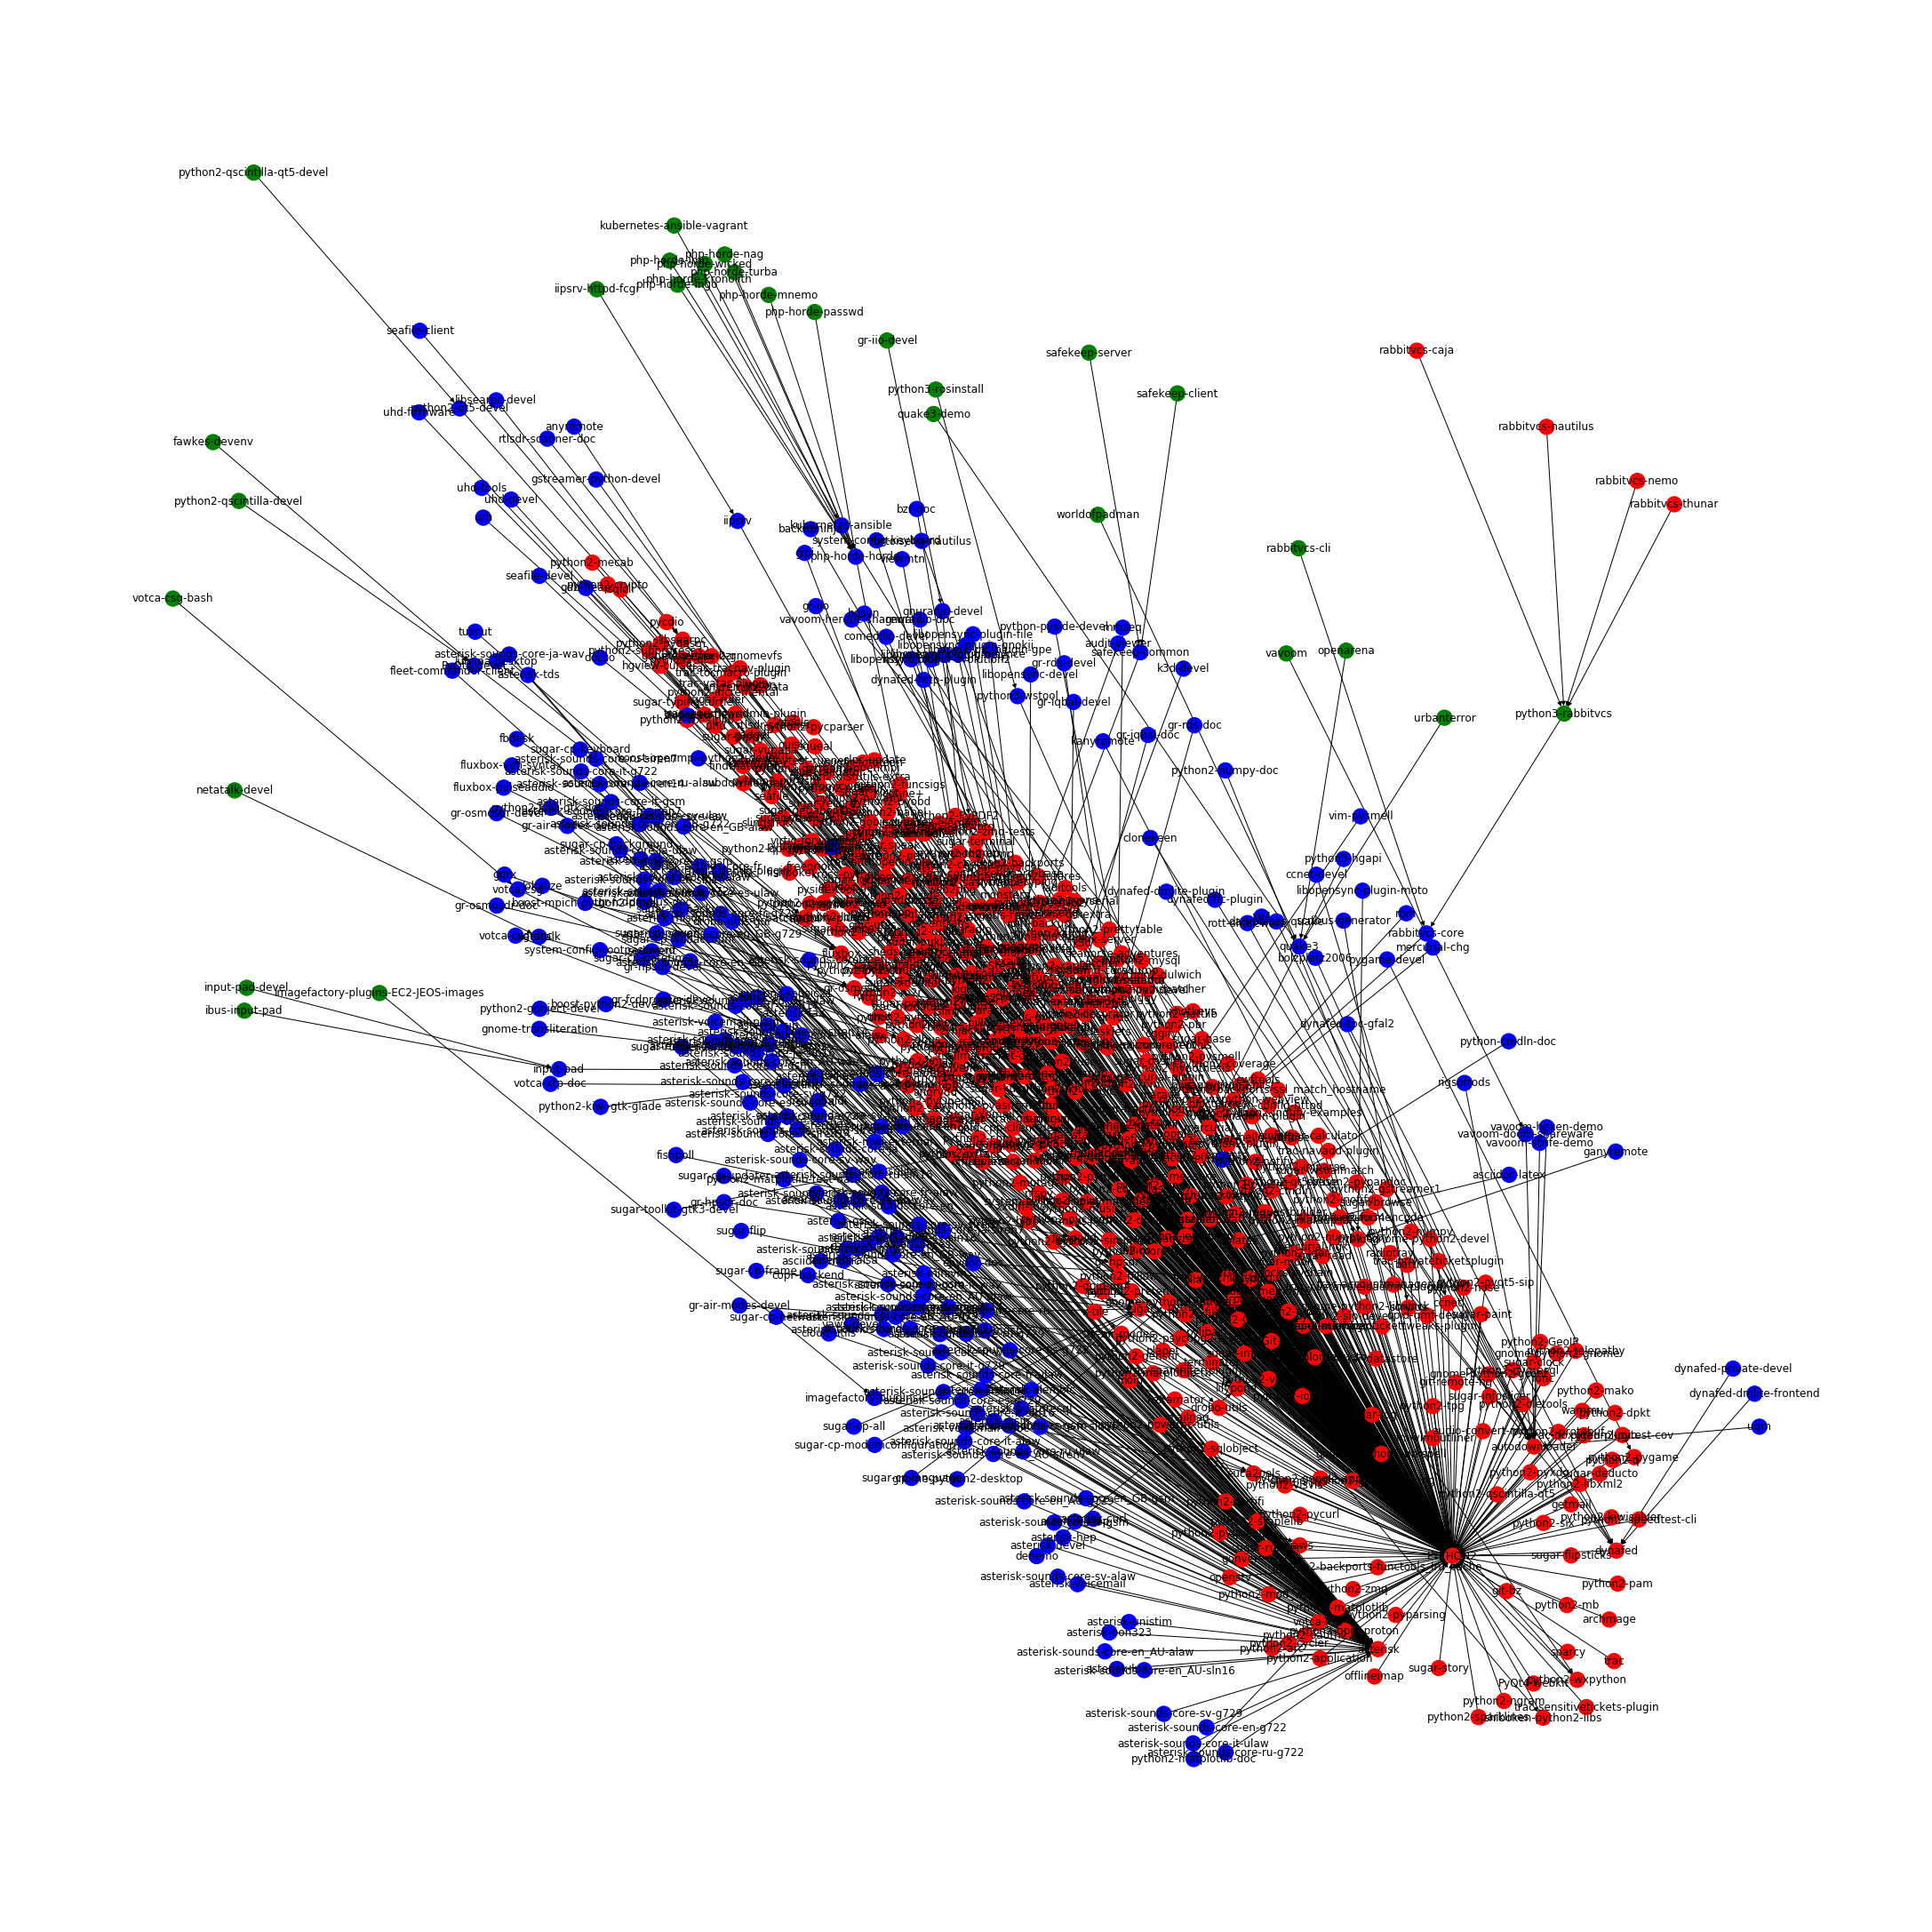

In [27]:
plt_draw(g, node_colors)

In [28]:
from networkx.algorithms.simple_paths import all_simple_paths
list(all_simple_paths(g, "rabbitvcs-nemo", "PYTHON2"))

[['rabbitvcs-nemo',
  'python3-rabbitvcs',
  'rabbitvcs-core',
  'mercurial',
  'PYTHON2']]

for sg in list(nx.weakly_connected_component_subgraphs(g_nc)):
    plt_draw(sg, figsize=(5,5))

## List of packages and theirs paths to Python 2 (including the packages in the first wave)

In [29]:
len(waves)

5

In [30]:
with open("packages.txt", "w") as packages_file:
    packages = list(chain(*[waves[str(n)] for n in waves.keys()]))
    print("Total packages", len(packages))
    for package in sorted(packages):
        path = list(all_simple_paths(g, package, 'PYTHON2'))[0]
        line = f"{package} ({' → '.join(path)})"
        print(line)
        print(line, file=packages_file)

!scp packages.txt fedorapeople.org:/home/fedora/lbalhar/public_html/ >/dev/null

Total packages 791
NFStest (NFStest → PYTHON2)
PyQt4 (PyQt4 → PYTHON2)
PyQt4-devel (PyQt4-devel → PyQt4 → PYTHON2)
PyQt4-webkit (PyQt4-webkit → PYTHON2)
PyRTF (PyRTF → PYTHON2)
RackTables (RackTables → PYTHON2)
TeXamator (TeXamator → PYTHON2)
alacarte (alacarte → PYTHON2)
angrydd (angrydd → PYTHON2)
anyremote (anyremote → anyremote-data → PYTHON2)
anyremote-data (anyremote-data → PYTHON2)
archivemail (archivemail → PYTHON2)
archmage (archmage → PYTHON2)
asciidoc-latex (asciidoc-latex → dblatex → PYTHON2)
asciidoc-music (asciidoc-music → lilypond → PYTHON2)
asterisk (asterisk → PYTHON2)
asterisk-ael (asterisk-ael → asterisk → PYTHON2)
asterisk-alembic (asterisk-alembic → asterisk → PYTHON2)
asterisk-alsa (asterisk-alsa → asterisk → PYTHON2)
asterisk-calendar (asterisk-calendar → asterisk → PYTHON2)
asterisk-corosync (asterisk-corosync → asterisk → PYTHON2)
asterisk-curl (asterisk-curl → asterisk → PYTHON2)
asterisk-dahdi (asterisk-dahdi → asterisk → PYTHON2)
asterisk-devel (asterisk-dev

## List of all SRPMs and theirs RPMs

In [31]:
inverse_map = {}
for srpm, pkgs in mapping.items():
    inverse_map.update({pkg: srpm for pkg in pkgs})

In [32]:
srpms = defaultdict(list)
for package in packages:
    try:
        srpm = inverse_map[package]
    except KeyError:
        srpm = "N/A"
    srpms[srpm].append(package)

## List of affected maintainers and their binary RPMs

In [35]:
affected_maintainers = defaultdict(list)
for package in packages:
    try:
        srpm = inverse_map[package]
    except KeyError:
        srpm = "N/A"
    for maintainer in maintainers.get(srpm, []):
        affected_maintainers[maintainer].append(package)

with open("affected_maintainers.txt", "w") as affected_maintainer_file:
    for maintainer, pkgs in sorted(affected_maintainers.items(), key=lambda x: x[0]):
        line = f"{maintainer} - {', '.join(pkgs)}"
        print(line)
        print(line, file=affected_maintainer_file)

!scp affected_maintainers.txt fedorapeople.org:/home/fedora/lbalhar/public_html/ >/dev/null

aarem - python2-PyPDF2, python2-staplelib, python2-more-itertools, pdf-stapler
abbot - python2-protobuf
abompard - python2-urllib3, python2-pysocks, python2-mako, python2-httplib2, python2-zope-event, python2-coverage, python2-requests
acaringi - cassandra-python2-cqlshlib, cassandra
ajmitchell - NFStest
alexl - gnome-python2-devel, gnome-python2-gconf, gnome-python2-rsvg, gnome-python2-libwnck, python2-ldap, gnome-python2-gtkspell, alacarte, gnome-python2-gnomekeyring, gnome-python2-gnome, python2-dbus, gnome-python2-gnomevfs, gnome-python2-canvas, gnome-python2-desktop
alexlan - tellico, graphviz-python2, bibus, dblatex
alikins - certmaster, func
amitshah - pius
amluto - python2-musicbrainzngs
andreamanzi - dynafed, dynafed-dmlite-frontend, dynafed-dmlite-plugin, dynafed-http-plugin, dynafed-lfc-plugin, dynafed-private-devel, dynafed-tpc-gfal2
anishpatil - gnome-transliteration
ankursinha - python3-wstool
antiaircraft - gst-entrans
anyremote - ganyremote, kanyremote
aperezbios - suga

## Recipients

In [36]:
recipients = set(affected_maintainers.keys())
print(f"Total recipients: {len(recipients)}")
for recipient in recipients:
    print(f"{recipient}@fedoraproject.org")

Total recipients: 341
itamarjp@fedoraproject.org
bkabrda@fedoraproject.org
ignatenkobrain@fedoraproject.org
jmlich@fedoraproject.org
mjw@fedoraproject.org
lzap@fedoraproject.org
aarem@fedoraproject.org
salimma@fedoraproject.org
sochotni@fedoraproject.org
andreamanzi@fedoraproject.org
jdekloe@fedoraproject.org
hguemar@fedoraproject.org
ishcherb@fedoraproject.org
jamatos@fedoraproject.org
plambri@fedoraproject.org
dfateyev@fedoraproject.org
sergiopr@fedoraproject.org
robled@fedoraproject.org
cicku@fedoraproject.org
abbot@fedoraproject.org
ffesti@fedoraproject.org
mcrha@fedoraproject.org
jhladky@fedoraproject.org
apevec@fedoraproject.org
irina@fedoraproject.org
bpepple@fedoraproject.org
daveo@fedoraproject.org
ianweller@fedoraproject.org
genodeftest@fedoraproject.org
besser82@fedoraproject.org
tommi@fedoraproject.org
pingou@fedoraproject.org
jpopelka@fedoraproject.org
miminar@fedoraproject.org
tmraz@fedoraproject.org
ilianaw@fedoraproject.org
sgrubb@fedoraproject.org
pwouters@fedoraprojec

# Build dependencies (direct)

In [64]:
srpm_dependants = []
for package in sorted(packages):
    build_requires = !dnf --repo=rawhide-source --repo=rawhide repoquery --qf "%{{NAME}} %{{ARCH}}" --whatrequires {package} 2>/dev/null | grep " src$" | cut -d " " -f 1
    print(f"{package} in required in build time by {build_requires}")
    for pkg in build_requires:
        srpm_g.add_edge(pkg, package)
    srpm_dependants.extend(build_requires)

NFStest in required in build time by []
PyQt4 in required in build time by []
PyQt4-devel in required in build time by ['gnuradio', 'gr-air-modes', 'hgview', 'pilas', 'python-poppler-qt4', 'qscintilla']
PyQt4-webkit in required in build time by []
PyRTF in required in build time by []
RackTables in required in build time by []
TeXamator in required in build time by []
alacarte in required in build time by []
angrydd in required in build time by []
anyremote in required in build time by []
anyremote-data in required in build time by []
archivemail in required in build time by []
archmage in required in build time by []
asciidoc-latex in required in build time by []
asciidoc-music in required in build time by []
asterisk in required in build time by []
asterisk-ael in required in build time by []
asterisk-alembic in required in build time by []
asterisk-alsa in required in build time by []
asterisk-calendar in required in build time by []
asterisk-corosync in required in build time by []

In [72]:
source_packages_set = set(srpm_dependants) 

In [73]:
len(source_packages_set)

397

In [74]:
only_new_srpms = source_packages_set - set(srpms.keys())

In [75]:
len(only_new_srpms)

71

In [76]:
c = 0
next_affected_maintainers = []
for srpm in sorted(only_new_srpms):
    try:
        rpms = mapping[srpm]
    except KeyError:
        print(f"Cannot get RPMs for {srpm}")
        continue
    if any([p.startswith("python2-") for p in rpms]):
        pass
        print(f"✅ {srpm} provides python2 subpackage - {rpms}")
    else:
        c += 1
        print(f"⁜ {srpm} does not provide python2 subpackage - {rpms}")
        next_affected_maintainers.extend(maintainers.get(srpm, []))

⁜ asv does not provide python2 subpackage - ['asv', 'asv-doc']
⁜ avogadro does not provide python2 subpackage - ['avogadro-libs', 'avogadro', 'avogadro-devel', 'avogadro-i18n']
⁜ b43-openfwwf does not provide python2 subpackage - ['b43-openfwwf']
⁜ bamf does not provide python2 subpackage - ['bamf-daemon', 'bamf', 'bamf-devel']
⁜ caja-actions does not provide python2 subpackage - ['caja-actions-doc', 'caja-actions', 'caja-actions-devel']
⁜ certmonger does not provide python2 subpackage - ['certmonger']
✅ check-mk provides python2 subpackage - ['check-mk-livestatus', 'check-mk-multisite', 'check-mk', 'python2-cmk', 'check-mk-docs', 'check-mk-agent']
⁜ copr-frontend does not provide python2 subpackage - ['copr-frontend-doc', 'copr-frontend-devel', 'copr-frontend', 'copr-frontend-fedora']
⁜ cxxtest does not provide python2 subpackage - ['cxxtest', 'cxxtest-doc']
⁜ dbus does not provide python2 subpackage - ['dbus-x11', 'dbus-doc', 'dbus-devel', 'dbus-daemon', 'dbus-libs', 'dbus-common', '

In [77]:
c

68

In [78]:
len(set(next_affected_maintainers) - set(affected_maintainers))

45